In [ ]:
import torch

## Data load

We begin by loading the necessary data, which will consist of names. The ultimate goal of the algorithm is to generate names. To achieve this, the model will start with three input characters and generate the next character in the sequence. This newly generated character will appended as last character of the previous three and the first one will be removed and then be used as input to predict the subsequent one, and this process will continue...

The models we will implement are character-level language models, meaning they predict the next character in the sequence based on one or more preceding characters.

### Example of how it works

Lets suposuse that our model finally predict the name `hermione`, the sequence will be as follow:

| Input | Output (model prediction) |
|-------|---------------------------|
| ...   | h                         |
| ..h   | e                         |
| .he   | r                         |
| her   | m                         |
| erm   | i                         |
| rmi   | o                         |
| mio   | n                         |
| ion   | e                         |
| one   | .                         |

In [ ]:
words = open("data/kharpathy/names.txt", "r").read().splitlines()

print(f"The dataset contains {len(words)} names.")

The dataset contains 32033 names.


In [ ]:
# As an example, some of the names in the dataset are ...
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

Now we are going to build to dictionaries:
* `stoi`: map each character to its corresponding index -> `{'.':0, 'a':1, ...}`
* `itos`: map each character index to its corresponding character -> `{0:'.', 1:'a', ...}`

In [ ]:
uniques_characters = sorted(set(''.join(words)))
itos = {idx+1:uniq_char for idx, uniq_char in enumerate(uniques_characters)}
itos[0] = '.'

stoi = {v:k for k,v in itos.items()}

print(itos)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


### Buiding samples tensors

Now we build the tensors that will contain the samples. Our goal is to end having two tensors:
* A inputs tensor `X` that will have shape `num_samples, 3`, being this 3 because each input is formed by 3 characters.
* A labels tensor `Y` that will have shape `num_samples`, being each element the index of the expected follwing character.

Because maybe in the future we want to modify the number of characters that our model take as input we will parametrize this value in a variable called `block_size`.

We will start creating a dataset with the samples from the first `5` names.

In [ ]:
block_size = 3
X, Y = [], []

for word in words[:5]:
  print(word)
  input = [0]*block_size
  for ch in word+'.':
    print(f"Input: {[itos[i] for i in input]} ------> Label: {ch}")
    ch_ix = stoi[ch]
    X.append(input.copy())
    Y.append(ch_ix)
    input = input[1:] + [ch_ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
Input: ['.', '.', '.'] ------> Label: e
Input: ['.', '.', 'e'] ------> Label: m
Input: ['.', 'e', 'm'] ------> Label: m
Input: ['e', 'm', 'm'] ------> Label: a
Input: ['m', 'm', 'a'] ------> Label: .
olivia
Input: ['.', '.', '.'] ------> Label: o
Input: ['.', '.', 'o'] ------> Label: l
Input: ['.', 'o', 'l'] ------> Label: i
Input: ['o', 'l', 'i'] ------> Label: v
Input: ['l', 'i', 'v'] ------> Label: i
Input: ['i', 'v', 'i'] ------> Label: a
Input: ['v', 'i', 'a'] ------> Label: .
ava
Input: ['.', '.', '.'] ------> Label: a
Input: ['.', '.', 'a'] ------> Label: v
Input: ['.', 'a', 'v'] ------> Label: a
Input: ['a', 'v', 'a'] ------> Label: .
isabella
Input: ['.', '.', '.'] ------> Label: i
Input: ['.', '.', 'i'] ------> Label: s
Input: ['.', 'i', 's'] ------> Label: a
Input: ['i', 's', 'a'] ------> Label: b
Input: ['s', 'a', 'b'] ------> Label: e
Input: ['a', 'b', 'e'] ------> Label: l
Input: ['b', 'e', 'l'] ------> Label: l
Input: ['e', 'l', 'l'] ------> Label: a
Input: ['l', 'l

In [ ]:
# Dataset dimensions and types
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## Neural network architecture

We want to recreate the network from the paper [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). The proposed network have the following architecture:

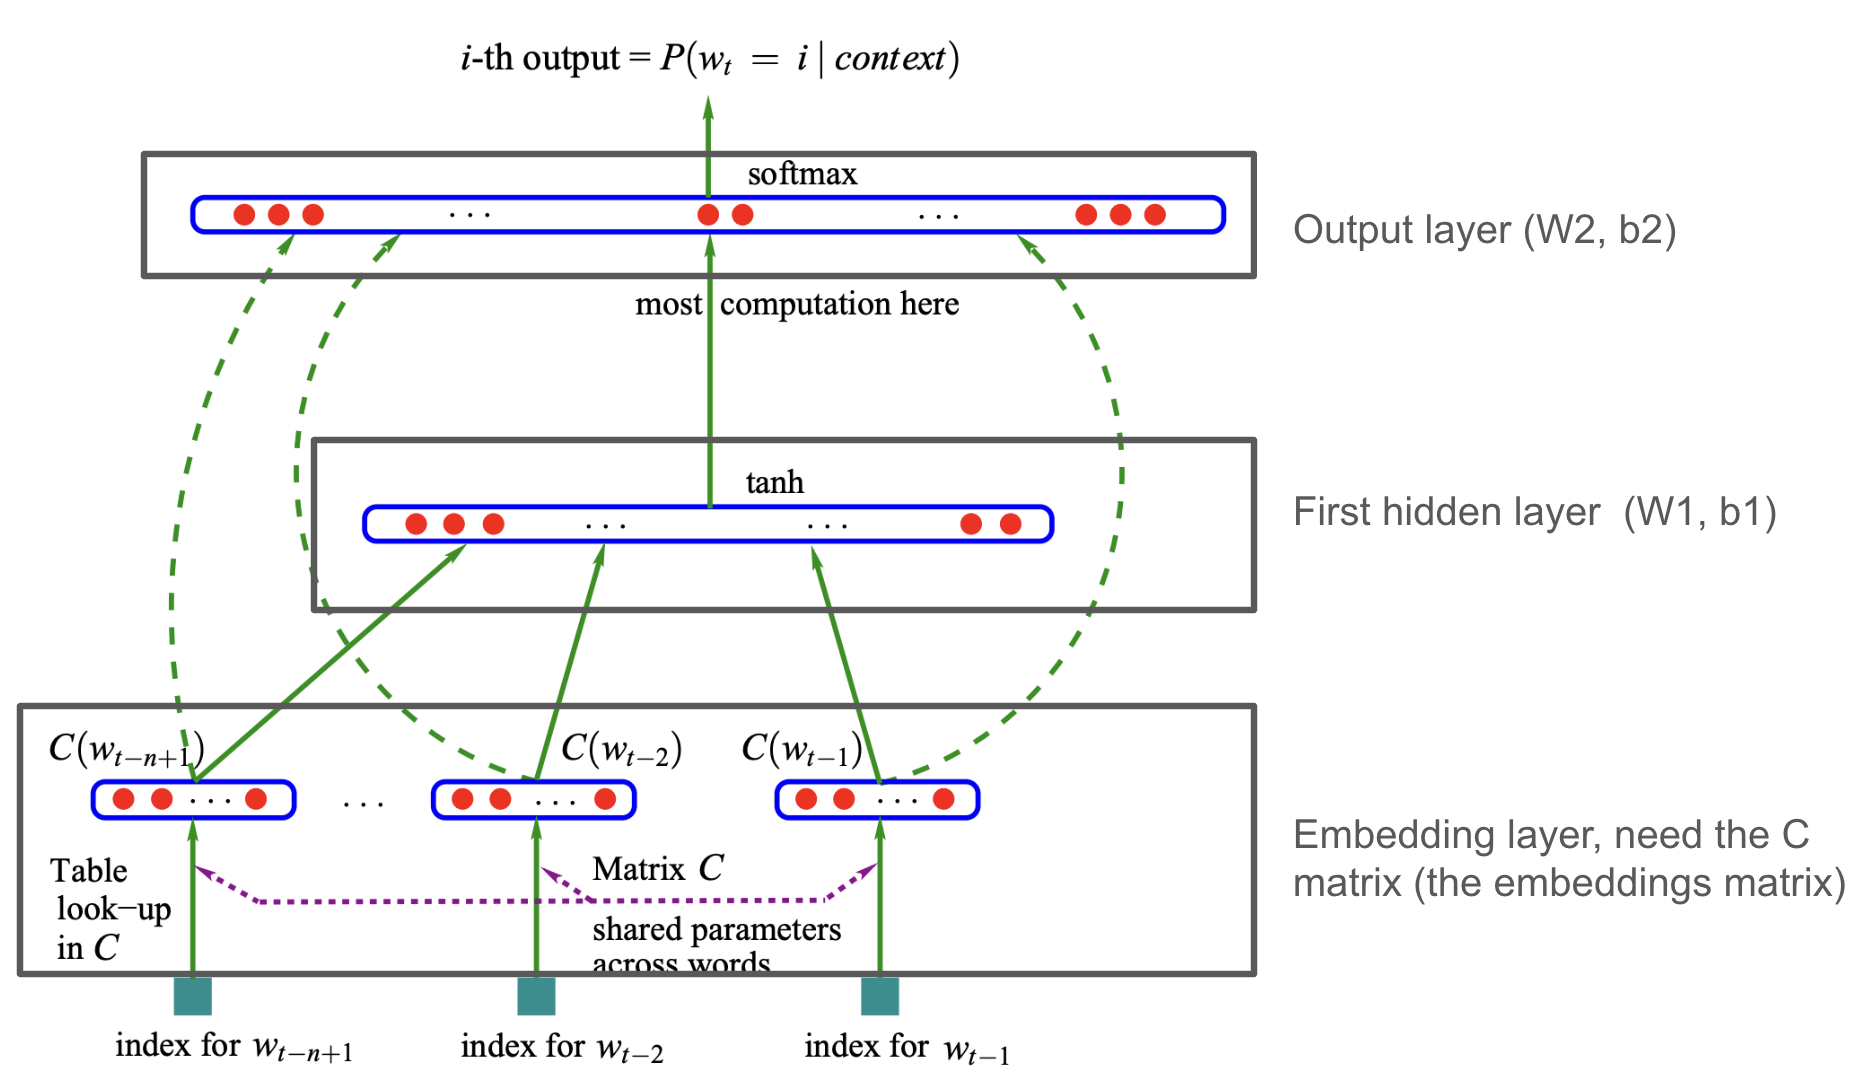

## C matrix

The matrix C will contain the embeddings for each token. In our case this dimensions will be stored as 2 dimensions vectors (each row in C matrix).

So the shape of C will be `vocabulary_size, 2`. The `vocabulary_size`is equivalent to the number of uniques tokens in our dataset, in pur case, ecause we are building a character level config we have `27` uniques tokens: 26 uniques alphabetical character + the start and end token `'.'`.

Initially the C matrix's weights will be random. Our goal is that during the training of the neural network this weights (embeddings) achieve a meaninfull representation of every token. We will see later what this means.

In [ ]:
vocabulary_size = len(stoi.items())
embedding_dimensional_space = 2

C = torch.randn(vocabulary_size, embedding_dimensional_space)

print(C.shape)

torch.Size([27, 2])


### How to retrieve elements embeddings from C matrix

Now that we have created the C matrix, we are going to need to retrieve rows (embeddings) from it during the training, evaluation and inference steps (all the lifecycle). How can we do this?

There is at least two ways of accesing to this rows:
* C matrix indexing
* Using the one-hot encoding method

Let see them:

### C matrix indexing

Let say that we want to get the embedding that correspond to the character `e`, ie. the character with the index `5`. We can simply do:

In [ ]:
C[5]

tensor([-0.9244, -1.3332])

### One-hot encoding method (Matrix multiplication)

We can also transform the required index `5` in a one-hot encoding vector and perform a matrix multiplication with C in order to get the required element:

In [ ]:
import torch.nn.functional as F

# We need to transform 5 in a tensor in order to be able to apply the @ operator
# We also nees to cast the tensor as a float in order to be able to apply the @ operator
F.one_hot(torch.tensor(5), num_classes = vocabulary_size).float() @ C

tensor([-0.9244, -1.3332])

Let see which one of this two approach is faster

In [ ]:
%%timeit -n 10 -r 1000
C[5]

The slowest run took 62.11 times longer than the fastest. This could mean that an intermediate result is being cached.
3.39 µs ± 7.66 µs per loop (mean ± std. dev. of 1000 runs, 10 loops each)


In [ ]:
time_tens = F.one_hot(torch.tensor(5), num_classes = vocabulary_size).float()

In [ ]:
%%timeit -n 10 -r 1000
time_tens @ C

The slowest run took 43.05 times longer than the fastest. This could mean that an intermediate result is being cached.
9.03 µs ± 11.9 µs per loop (mean ± std. dev. of 1000 runs, 10 loops each)


As we can see even given a little advantage to the one-hot encoding method precomputing and precasting it, because in the real case we would need to create every time the one hot encoding vector or retrieve it from another matrix, we can see that this method as two times slower that the simple index version. So we will stick to index version.

Now that we know how to retrieve a given embedding for a single sample, via indexing, let see how we can we retrieve more than one at the same time. We will require of this feature if we want, for example, train the network with more that just one sample at a time, which would be extremely inefficient.

It is not a hard task. If we want for example retrieve the embeddings of a list of indexes, we can just wrap these indexes in a list a index C matrix with this list:

In [ ]:
required_indexes = torch.tensor([5, 6, 7, 7, 7, 7, 7])

C[required_indexes]

tensor([[-0.9244, -1.3332],
        [-0.5266,  1.1222],
        [-0.8695,  0.5133],
        [-0.8695,  0.5133],
        [-0.8695,  0.5133],
        [-0.8695,  0.5133],
        [-0.8695,  0.5133]])

We can do exactly the same but instead of a list using the inputs indexes from the `X` tensor:

In [ ]:
x_embeddings = C[X]
x_embeddings.shape

torch.Size([32, 3, 2])

As we can see the resulting tensor `x_embeddings` has a shape of `(32, 3, 2)`:
* `32` because we have this number of samples in `X`
* `3` because our `block_size`
* `2` because the dimensional space of the embeddings in C matrix

We can check that `x_embeddings` contains the correct information:

In [ ]:
print(X[13, 2])

# We will get the same embedding indexing and getting the element and getting directly the element from C
print(C[X][13, 2])
print(C[1])

tensor(1)
tensor([-0.1444, -0.0319])
tensor([-0.1444, -0.0319])


### Ways to index

Now that we have choose indexing as the way to retrieve embeddings from the C matrix we have to choose the way to index. Pytorch offers us a wide variety of options when it comes to get elements from a tensor by indexing.

The first way is simply using a list of elements:

In [ ]:
# As we can see we get the rows with indexes: 0, 4 and 8 (two times)
C[[0,4,8, 8]]

tensor([[-0.3070, -0.4225],
        [ 1.3609,  1.1722],
        [ 0.5045, -0.6298],
        [ 0.5045, -0.6298]])

We can do the same but using a tensor

In [ ]:
# We get exactly the same result than previously
C[torch.tensor([0, 4, 8, 8])]

tensor([[-0.3070, -0.4225],
        [ 1.3609,  1.1722],
        [ 0.5045, -0.6298],
        [ 0.5045, -0.6298]])

In the previous example we have indexed using a one dimensional tensor as index tensor, but we can also use multidimensional tensors to index another tensor. When we use a unidimensional tensor each value means a index in the first dimension (dimension with index 0 or rows) and it works in the same way when we use multidimensional tensor as an index tensor. In the following example the indexes tensor is `2, 4` and the output (after the indexing) is `2, 4, 2` this means that the index still refers to the rows, we are just conditioning the output shape with the indexing tensor's shape.

In [ ]:
print(torch.tensor([[0, 4, 8, 8],[0, 4, 8, 8]]).shape)
C[torch.tensor([[0, 4, 8, 8],[0, 4, 8, 8]])].shape

torch.Size([2, 4])


torch.Size([2, 4, 2])

## First hidden layer (W1, b1)

In [ ]:
# Let's store the dataset samples embeddings in a variable in orde to make it
# easy to access to them in the following steps
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

The next step is create the parameters that will represent the weights of the first hidden layer. This layer will have also bias weights so we need to create this parameters additionaly.

We will create two matrices:
* `W1` with the multyping weights
* `b1` with the adding weights (bias)

The amount of neurons in this layer will be arbitrary. We will set it to `100` but any other value will be also valid. This parameter will be common to `W1` and `b1` because `b1` is added to `W1` outputs (after multiply `W1` with the embeddings).

The input shape is another parameter that we need to know in order to create the matrix `W1` because we need that this shape match with the output parameters that come from the previous layer. In our case the number of tokens on each sample is `3` (`block_size`) and `W1` take as input the embedding for each character ie. each character is represented by a embedding of `2` dimensions. Thats why `W1` needs an input shape of `6` (`3*2 = 6`).

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.rand(100)

Now if we simply execute `emb @ W1 + b1` torch is going to raise an error because the shape of `emb` ie. `(32, 3, 2)` (we can ignore the `32` because is just the batch size or the number of samples computed at the same time, so it could be any amount) do not match with the expected input shape for `W1`. We need to reorder `emb` if we want to execute the matrix multiplication.

At high level the transformation that we need to do is concatenate for each sample the representation of the `3` embeddings, each of them with `2` dimensions, going from `(32, 3, 2)` to `(32, 6)`

There are many ways to do this in pytorch. Some of them are:
* Concatening with `torch.cat` method and manually creating sequence
* Concatening with `torch.cat` method and use the `torch.unbind` method
* Using the `view` method

### Concatening with `torch.cat` method and manually creating sequence

This approach is very simple. We just need to create an array (even a list is ok) of the tensors that we want to concatenate and the dimension over which the tensors are concatenated.

In the following example we are going to create 3 arrays:
* One of them with the embeddings of the first characters of the samples
* Another of them with the embeddings of the second characters of the samples
* One last with the embeddings of the first characters of the samples

To get the embeddings from one of the tokens we are going to use de following method `emb[:, char_ix, :]`. The two `:` means that we want all the elements in the first and last dimension which means: I want the embeddings from all samples in `emb[:, 0, :]` (first `:`) and all the dimensions (`2` in our case) for each embedding (second `:`). The `char_ix` tells to the slicing mechanism from which character in the input sequence (`block_size`) we want the embeddings.

In [ ]:
char_0_tensor = emb[:, 0, :]
char_1_tensor = emb[:, 1, :]
char_2_tensor = emb[:, 2, :]

print(char_0_tensor.shape)
print(char_1_tensor.shape)
print(char_2_tensor.shape)

torch.Size([32, 2])
torch.Size([32, 2])
torch.Size([32, 2])


Now that we have our tensors we just need to put them in a sequence (a list) and choose over which one of the two dimension (each tensor have now two dimensions: rows and column or said another way samples and embedding's dimensions)

In the following cell we can see how modifyng the dim in concatenation provides different results.

In [ ]:
sequence = [char_0_tensor, char_1_tensor, char_2_tensor]

concat_by_dim0 = torch.cat(sequence, dim=0)
concat_by_dim1 = torch.cat(sequence, dim=1)

print(concat_by_dim0.shape)
print(concat_by_dim1.shape)

torch.Size([96, 2])
torch.Size([32, 6])


We can see that when we concat by `dim = 0` we concat by rows and then we create a tensor with combined number of rows of all the tensors. In the same way when we concat by `dim = 1` we concat columns so we have the combined number of columns but the same ammount of rows.

Because we want concat by columns (in order to get `32, 6`) we will choose `dim=1`.

So sumarizing the code it will be something like:

In [ ]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

This approach, using `torch.cat` have at least one problem. If we modify the `block_size` we need to modify the code in order to include more tensors in the sequence. For example if `block_size=4` we should do:

`torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :], emb[:, 3, :]], dim=1).shape`

### Concatening with `torch.cat` method and use the `torch.unbind` method

We can also use the `unbind` method. This method receives a tensor and the index of a dimension and it remove the dimension splitting the tensor in a sequence (tuple) of tensors.

Let see how it works with some examples:

In [ ]:
ex_0 = torch.unbind(emb, dim=0)
ex_1 = torch.unbind(emb, dim=1)
ex_2 = torch.unbind(emb, dim=2)

print(f"Original shape: {emb.shape}")
print(f"Type: {type(ex_0)}. Tensors in sequence: {len(ex_0)}. Result's shape: {ex_0[0].shape}")
print(f"Type: {type(ex_1)}. Tensors in sequence: {len(ex_1)}. Result's shape: {ex_1[0].shape}")
print(f"Type: {type(ex_2)}. Tensors in sequence: {len(ex_2)}. Result's shape {ex_2[0].shape}")

Original shape: torch.Size([32, 3, 2])
Type: <class 'tuple'>. Tensors in sequence: 32. Result's shape: torch.Size([3, 2])
Type: <class 'tuple'>. Tensors in sequence: 3. Result's shape: torch.Size([32, 2])
Type: <class 'tuple'>. Tensors in sequence: 2. Result's shape torch.Size([32, 3])


The point of using the `unbind` method is that we do not need to manually create the sequence and in this way if in the future we decide to modify the `block_size` parameter our code will still work as long as the character sequence is represented by the dimmesion 1 (`dim=1`).

Then, if we decide to go with this approach we could do it as follow:

In [ ]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape

torch.Size([32, 6])

As a result we get th desired `32, 6` sample's embbeding matrix.

### Using the `view` method

The option to use the `unbind` technique is scalable as we have seen but there is yet a better option. When we work with neuroal network we should try to do all the operations in the most efficient way. The two previous methods, the methods that involve `torch.cat` create as a result a new tensor with the memory and computation cost that this action have, but at the end we do not need a new tensor, we just need to modify or adapt the shape of our current `emb` tensor, this is what `view` method do exactly.

The `view` method change the way that the order of the elements in the memory is treated, so no need to create a new tensor just to 'reorder' it. The only argument that `view` needs is the shape of the resulting tensor. The product of the new dimensions should match with the product of the original dimension, what at the end means that both representations should contain the same ammount of elements. Let's put an example:

If I have a tensor `tmp_tensor` with shape `32, 4, 5` (`32*4*5=640`) we can apply a view with `32, 20` (`32*20=640`), or `2,2,5,32` (`2*2*5*32=640`) or `640` but we **CAN'T** apply `3, 2, 1` or `10, 20, 3` or any other combination that the product of the elements in all dimensions is not `640`.

In [ ]:
torch.randn((32,4,5)).view((2,2,5,32)).shape

torch.Size([2, 2, 5, 32])

So if we decide to use the `view` method we can just tell to it that we need `6` elements in the second (index 1) dimension. We do not even need indicate the other dimension, we can indicate with `-1` that torch should infer it. As it obvious that torch just can to infer one dimension at the same time, so we can just include one `-1`

In [ ]:
emb.view((-1, 6)).shape

torch.Size([32, 6])

And we achieve again the same result.

Finally lets compare the time that it takes using the `view` method vs the `cat` with `unbind`:

In [ ]:
%%timeit -n 10 -r 1000
torch.cat(torch.unbind(emb, dim=1), dim=1)

The slowest run took 35.95 times longer than the fastest. This could mean that an intermediate result is being cached.
22.5 µs ± 31.4 µs per loop (mean ± std. dev. of 1000 runs, 10 loops each)


In [ ]:
%%timeit -n 10 -r 1000
emb.view((-1, 6)).shape

The slowest run took 132.13 times longer than the fastest. This could mean that an intermediate result is being cached.
3.76 µs ± 11.5 µs per loop (mean ± std. dev. of 1000 runs, 10 loops each)


As we can see the `view` method is more than 3 times faster that the alternative. So we will continue with the `view` option.

In [ ]:
# h for hidden state
h = emb.view((-1, 6)) @ W1 + b1

h.shape

torch.Size([32, 100])

As we can see the ouput of the first hidden layer (`h` tensor) have 32 rows (one for each input sample) and 100 values per sample (one for each output neuron).

We can put some attention here in the way that the addition work via **broadcasting**. Lets check the intermediate sizes:

In [ ]:
print(f"Product result shape: {(emb.view((-1, 6)) @ W1).shape}")
print(f"Bias tensor shape: {b1.shape}")

Product result shape: torch.Size([32, 100])
Bias tensor shape: torch.Size([100])


As we can see torch is smart enough to broadcast the bias tensor along all the 32 elements in the product result tensor. Broadcasting has worked in the following way:
* Get the dimmension of the two terms that we are going to add: `(32,100)` and `(100)`
* Adding dimensions (of size 1) to the beginning of the tensor until both dimensions have the same number of elements: `(100)` -> `(1,100)` (The vector become a matrix of `1` row)
* Copy the new created row until it matches the other matrix shape: `(1,100)` -> `(32,100)`
* Execute the addition of the two matrices (now both matrices have the same shape `32,100`)

### Tanh function

If we take a look to the values of `h` we can see that some of them can be high comparing with others:

In [ ]:
print(f"Max value in h: {torch.max(h).item()}")
print(f"Min value in h: {torch.min(h).item()}")

Max value in h: 9.451931953430176
Min value in h: -7.328983306884766


In order to avoid this situation, we need to map all the values to values between `-1` and `1`. This mapping is achieved with the `torch.tanh` function. Lets take a look to this function:

Text(0, 0.5, 'tanh(x)')

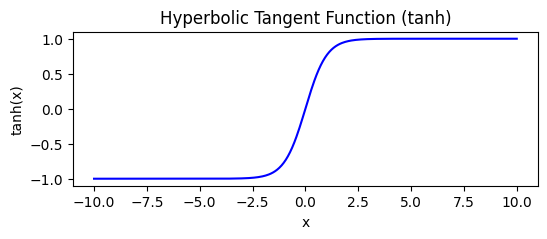

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the tanh function
def tanh(x):
    return np.tanh(x)

# Generate x values from -5 to 5
x_values = np.linspace(-10, 10, 400)

# Compute the corresponding y values using the tanh function
y_values = tanh(x_values)

# Create the plot
plt.figure(figsize=(6, 2))
plt.plot(x_values, y_values, label='tanh(x)', color='blue')

# Add title and labels
plt.title('Hyperbolic Tangent Function (tanh)')
plt.xlabel('x')
plt.ylabel('tanh(x)')

Then we should calculate a new `h` tensor applying `torch.tanh()` to the previous `h`.

In [ ]:
h = torch.tanh(h)

Now we can see that all values in `h` are between `-1` and `1`

In [ ]:
print(f"Max value in h: {torch.max(h).item()}")
print(f"Min value in h: {torch.min(h).item()}")

Max value in h: 1.0
Min value in h: -0.9999991655349731


## Output layer (W2, b2)

As we have done with the hidden layer, in order to create the new layer the first thing that we need to define is the number of inputs and outputs. This layer will take as input the output of the hidden layer, then because the hidden layer have `100` elements in the output `W2` should have `100` elements in the input.

It is worth mentioning that although the dimensions of the output tensor h calculated previously are 32,100, we are primarily interested in the second dimension. The first dimension is determined solely by the number of samples we have chosen and could vary in the future if we select fewer or more names (for example, if we work with the entire dataset). However, the code will continue to function correctly thanks to broadcasting.

Now that we have set the number of input dimensions lets think about the output one for `W2`. This is gone to be the last layer in our network ie. the output layer, and we want that our network's output represent a probability distribution that give a probability to every possible character or token, we have `27` uniques characters in our dataset. Then our output dimension should be `27` for `W2`.

Now that we now the dimmensions for `W2` we can set the dimensions for `b2`. `b2` will be a bias vector and will be applied to the product of `h` and `W2`, this product will have the same dimension that the output dimension of `W2`. Therefore, the bias vector that we will add to this output must also have the same number of elements. Consequently, `b1` will have `27` elements.

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.rand(27)

Now we simply can calculate the output of this last layer. Because we want to apply this output to the `Softmax` method to get probability distributions, and we remember from the previous video that the inputs to the `Softmax` are called `logits` we will give this name to the output of the last layer.

In [ ]:
logits = h @ W2 + b2

# We can check the logits shape, to check that it is OK
print(logits.shape)

torch.Size([32, 27])


The steps to implement softmax are as follow:
* Obtain the values that will serve as input (`logits`). This values can be positive and negatives
* Exponenciate the `logits` to make them positives and get the fake `counts`
* Normalize these `counts` adding all of them and dividing by the this sum to get the final probability distribution `prob`

Lets do these steps:

In [ ]:
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)

# We can check that the probability distribution has the correct shape:
# * First dimension: as many elements as input samples (32 in our case)
# * Second dimension: as many elements as unique tokens (27 in our case)
#   because we are assigning on probability to each token
print(probs.shape)

torch.Size([32, 27])


## Calculating the loss

Now that we have our network output we can start to evaluate it (in order to optimize the weights or parameters).

The first step is to obtain the probabilities that our network is assigning to the correct characters (labels) given the samples we have fed into the network. To do this, we need to extract from the output matrix `probs` the probabilities corresponding to the correct labels.

To get the required values from `probs` we will index the matrix.

The first index will represents the rows, because we want on value for each sample (because obviously all of these samples have a label), then we will create a list with all row's indexes `torch.arange(32)` (32 because we have this ammount of samples as input).

The second index is the correct character index (label), we estore this infomation in the label's tensor `Y`.

In [ ]:
print(torch.arange(32), '\n')
print(Y, '\n')

labels_probs = probs[torch.arange(32), Y]
labels_probs

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]) 

tensor([ 5, 13, 13,  1,  0, 15, 12,  9, 22,  9,  1,  0,  1, 22,  1,  0,  9, 19,
         1,  2,  5, 12, 12,  1,  0, 19, 15, 16,  8,  9,  1,  0]) 



tensor([3.6942e-11, 2.5759e-05, 9.2171e-07, 3.2383e-11, 2.8236e-01, 2.3315e-05,
        4.3628e-12, 1.0823e-07, 1.1711e-02, 3.1232e-07, 1.3465e-01, 1.0264e-03,
        2.5422e-12, 9.9831e-01, 5.6370e-09, 3.1728e-01, 5.9074e-10, 6.1557e-13,
        1.6977e-05, 3.2955e-04, 4.3636e-11, 6.2230e-14, 2.1840e-07, 1.5666e-07,
        8.7111e-01, 8.2868e-04, 4.1802e-05, 2.7812e-07, 1.9110e-08, 3.1176e-14,
        3.7560e-02, 6.7402e-07])

We can see that our model is yet untrained because is assigning low probabilities to the labels. Ideally all the `labels_probs` values should be high (don´t forget that the highest values that can take is `1` because they are probabilities) which would mean that our model is assigning a high probability to the correct character.


With the `labels_probs` vector extrated from `probs` we can calculate the Negative log likelihood loss value. The required steps to calculate this value are:
* Calculate the likelihood which means multiply all the probabilities. The grater the likelihood value the better (a model that assign `1` to all labels will be perfect and would has a likelihood `= 1*1*1....*1 = 1`).
* Because probabilities are `< 1` values if we multiply a bunch of them together we will have a very small value as a result. We should apply to them the `log` function in order to make them bigger.
* The `log` function add an issue, the resulting numbers are bigger in absolute value but they are negatives, so we need to multiply by `-1` in order to make them positive.
* Another thing that we should have into account after apply the `log` transformation is that a perfect likelihood of `1` will be mapped to a value of `0`. So in the log likelihood the smallest the value the better. This match with our intuition of a **loss** value, the smallest the value the better.
* Finally we need to calculate the average of the negative log likelihood to make the value comparable between loss calculated on diferent ammount of samples (make it usable and scalable)

In [ ]:
loss = -labels_probs.log().mean()
loss

tensor(14.1979)

## Code summary

In [ ]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

We will wrap the model creation in a function just to save some time copy and pasting the code all around...

In [ ]:
def get_base_model_params():
  g = torch.Generator().manual_seed(2147483647)
  C = torch.randn((vocabulary_size, embedding_dimensional_space), generator=g)
  W1 = torch.randn((6, 100), generator=g)
  b1 = torch.rand(100, generator=g)
  W2 = torch.randn((100, 27), generator=g)
  b2 = torch.rand(27, generator=g)

  parameters = [C, W1, b1, W2, b2]

  for p in parameters:
    p.requires_grad = True

  return C, W1, b1, W2, b2, parameters

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

In [ ]:
# Number of parameters in the network
model_numel = sum([p.numel() for p in parameters])
model_numel

3481

In [ ]:
emb = C[X] # emb.shape -> (32, 3, 2)
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
logits = h @ W2 + b2 # logits.shape -> (32, 27)
counts = logits.exp() # counts.shape -> (32, 27)
probs = counts / counts.sum(dim=1, keepdim=True) # probs.shape -> (32, 27)
labels_probs = probs[torch.arange(32), Y] # labels_probs.shape -> (32)
loss = -labels_probs.log().mean() # loss.shape -> (1)
loss

tensor(17.5373, grad_fn=<NegBackward0>)

### Replacing manual Negative Likelihood for torch Cross Entropy

Until now we have manually code de NLL loss function when deal with classification problems. Obviously the classification problem is a very common one in deep learning, that's why torch library have already implemented a mechanism that allow us to calculate a loss value when we want to classify, like in our language model (at last we are just classifying a given input, in this case a sequence of characters, and we are interpreting this classification as the next character in the sequence).

This function is `F.cross_entropy`. It will take as input the `logits` tensor and the labels tensor `Y`. So we could remove from our code all the intermediate steps from `logits` tensor to `loss` value.

In the next cell we will see that we get exactly the same result with the `cross_entropy` that in the manually calculated loss.

In [ ]:
print(f"Previously calculated loss value: {loss}")

import torch.nn.functional as F

cross_entropy_loss = F.cross_entropy(logits, Y)
print(f"Cross entropy function loss val.: {cross_entropy_loss}")

Previously calculated loss value: 17.537330627441406
Cross entropy function loss val.: 17.537330627441406


### Further reasons to use torch Cross entropy over manual NLL

There are more reasons to choose PyTorch's cross entropy implementation:

* #### Does Not Require Intermediate Tensors
In our implementation, we perform a series of intermediate steps whose results are stored in different tensors (which take up memory space): `logits`, `counts`, `probs`...
PyTorch's implementation avoids all these intermediate tensors, resulting in memory savings.

* #### Requires Fewer Mathematical Operations Due to Optimization
Fewer operations result in a simpler backpropagation process, which reduces the necessary computations.

* #### Better numerical stability or behaviour
he exponential function behaves appropriately with very negative values, mapping them to values very close to `0` (or approximately `0`). However, when we apply the exponential function to large positive values, such as `100`, the exponential function returns `inf`, which breaks subsequent operations. Let's observe this behavior with the following code example:

In [ ]:
sample_values = torch.tensor([-100, 0, 5, 10, 100])
sample_values.exp()

tensor([3.7835e-44, 1.0000e+00, 1.4841e+02, 2.2026e+04,        inf])

#### How cross entropy deal with `inf` issues

What the function does is substract from all the elements in the tensor the tensor's `max` value. It can be done because the softmax ouput of a tensor is the same that the nsoftmax ouput of the original tensor plus an offset.

In [ ]:
without_offset = torch.tensor([-5, -3, 0, 5])
without_offset = without_offset.exp()
without_offset = without_offset/without_offset.sum()
print(without_offset)

with_offset = torch.tensor([-5, -3, 0, 5]) + 10
with_offset = with_offset.exp()
with_offset = with_offset/with_offset.sum()
print(with_offset)

with_offset = torch.tensor([-5, -3, 0, 5]) - 15
with_offset = with_offset.exp()
with_offset = with_offset/with_offset.sum()
print(with_offset)

tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])
tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])
tensor([4.5079e-05, 3.3309e-04, 6.6903e-03, 9.9293e-01])


If we apply this method to the manual version we can overcome the issue:

In [ ]:
without_offset = torch.tensor([-5, -3, 0, 5, 10, 100])
without_offset = without_offset.exp()
without_offset = without_offset/without_offset.sum()
print(without_offset)

with_offset = torch.tensor([-5, -3, 0, 5, 10, 100])
with_offset = with_offset - torch.max(with_offset)
with_offset = with_offset.exp()
with_offset = with_offset/with_offset.sum()
print(with_offset)

tensor([0., 0., 0., 0., 0., nan])
tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 5.5211e-42, 8.1940e-40, 1.0000e+00])


As we can see the fixed version (with the substraction of the max value) assign a very high probability to the las element (the biggest one) and a very low (almost `0` probability) to the others.

## Network training

Finally we can create the training loop and start to train our neural network:

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

In [ ]:
for i in range(1000):
  emb = C[X] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y)

  if i%100 == 0:
    print(f"Step {i} loss value: {loss.item()}")

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

print(f"Final loss: {loss.item()}")

Step 0 loss value: 17.537330627441406
Step 100 loss value: 0.3203307092189789
Step 200 loss value: 0.2775940001010895
Step 300 loss value: 0.26733076572418213
Step 400 loss value: 0.26286283135414124
Step 500 loss value: 0.26036912202835083
Step 600 loss value: 0.2587781846523285
Step 700 loss value: 0.25767451524734497
Step 800 loss value: 0.25686347484588623
Step 900 loss value: 0.2562418580055237
Final loss: 0.2557545304298401


We are getting a very low loss (`0.2557545`), but we should not fool ourselves thinking that we already have a very good model because we are getting this so low loss because we are overfitting a small amount of samples (32 samples).

We should have also in mind that there is a limit than we can not surpass even overfitting this small set of samples ie. there is a small loss value that we can not reduce further, for example we can not get a `0` loss no matter how much we overtrain the model. The reason for this situation is because there is some sequences that have a given label from a given name but have another label in other name.

The most obvious example of this situation is the initial sequence, i.e., the sequence `'...'`. Although this sequence is always the same, its label will be different for each name, since each name starts with a different initial. Therefore, our network can never be 100% certain about which character it should predict for the input sequence `'...'`.

To visualize this situation we plot the first element of the `logits` tensor that we get in the last of the `1000` training steps. This first element `logits[0]` represent the `logits` generated by our network when we give `...` as input (there is other elements in the tensor `logits` that are generated with the same input because we have 5 names in `X` but we will take just the first ie. `logits[0]`). This `logits` should be later converted into probabilities but the larger ones (relative to the others) will be converted into higher probabilities, so comparing the values of the logits will give us an idea of the probabilities we would obtain later.

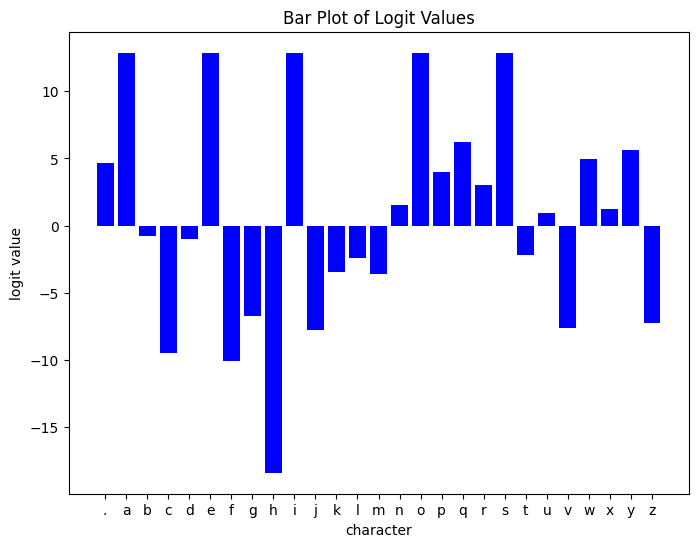

In [ ]:
import matplotlib.pyplot as plt

logit_values = logits[0].detach().numpy() # List of float values
characters = [key for key, value in sorted(stoi.items(), key=lambda item: item[1])]   # Corresponding characters for each bar

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(characters, logit_values, color='blue')

# Label the axes
plt.ylabel('logit value')
plt.xlabel('character')

# Add title for better understanding (optional)
plt.title('Bar Plot of Logit Values')

# Show the plot
plt.show()


As we can see, there are several characters that receive a high logit value, which means the network assigns them high probabilities. In this case, logically, these characters with high probabilities correspond to the initials of the names we have included in the batch X: `e` for emma, `o` for Olivia, `i` for isabella, `a` for ava, and `s` for sophia.

Therefore our network can never be completely sure which character to predict is the correct one given the input `'...'` and it can never obtain a loss of `0`.

In the same way that there are sequences that can have different labels, there are others that only have a single possible label (at least in the data with which we trained the network) since they only appear once or whenever they appear they are followed by the same character.

An example of this situation, although there are many others in our small set of 5 names, in fact it is the most common situation given the little variety present in the dataset, is the sequence `'emm'`, this sequence appears only once, for the name emma, and therefore only has one possible label: the letter `'a'`. Let's see what values ​​our network generates in this case for the logits of the input `'emm'`. (this logits can be found in the row 3 ie. `logits[3]`)

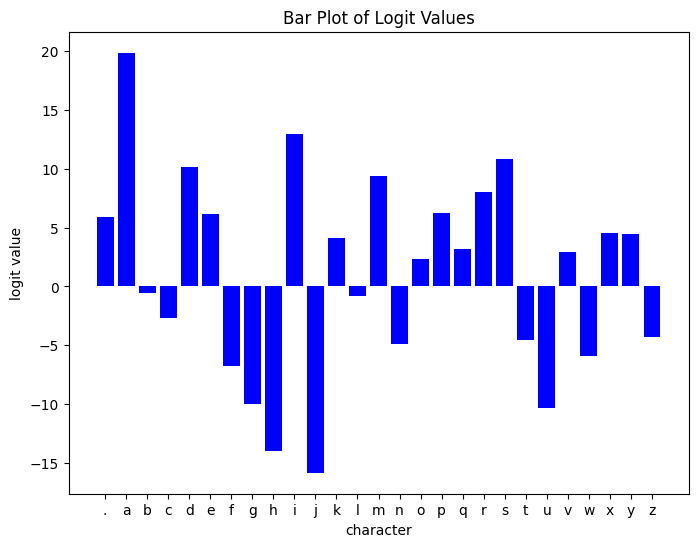

In [ ]:
import matplotlib.pyplot as plt

logit_values = logits[3].detach().numpy() # List of float values
characters = [key for key, value in sorted(stoi.items(), key=lambda item: item[1])]   # Corresponding characters for each bar

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(characters, logit_values, color='blue')

# Label the axes
plt.ylabel('logit value')
plt.xlabel('character')

# Add title for better understanding (optional)
plt.title('Bar Plot of Logit Values')

# Show the plot
plt.show()



As we can see, in this case there is a clear winner whose logit value far exceeds the rest, that of the character `a` as expected.

## Full dataset training

Below we include the code necessary to train our network with the entire data set, instead of just the first 5 names as we have done until now.

In [ ]:
block_size = 3
X, Y = [], []

for word in words:
  input = [0]*block_size
  for ch in word+'.':
    ch_ix = stoi[ch]
    X.append(input.copy())
    Y.append(ch_ix)
    input = input[1:] + [ch_ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

Since we are now training our network with the entire training set, the time needed for each step increases a lot. Let's count it.

In [ ]:
import time

for i in range(10):
  start_time = time.time()

  emb = C[X] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y)

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"Iteration {i+1}: {elapsed_time:.4f} seconds")

Iteration 1: 1.1290 seconds
Iteration 2: 1.0178 seconds
Iteration 3: 0.7152 seconds
Iteration 4: 0.6837 seconds
Iteration 5: 0.6867 seconds
Iteration 6: 0.6675 seconds
Iteration 7: 0.6573 seconds
Iteration 8: 0.6629 seconds
Iteration 9: 0.6825 seconds
Iteration 10: 0.6675 seconds


We see that the times are close to `1`, `0.8` to be exact, seconds per iteration, this delay begins to be a problem if we want to train the model for `1000` epochs, we will have to wait about 800 seconds, that is, more than 10 minutes waiting.

When we work we real datasets what we do is on each step (iteration of the train loop) we optimize the network using a random small portion (32, 64, 128 ... samples aka minibatch) randomly selected from the dataset.

Let create a minibatch:

In [ ]:
minibatch_size = 32

# We generate 32 (minibatch_size) random integers from zero to number of samples
# And later we will use these indexes to get samples from the dataset
# The point is that we'll do it (select random samples) on each iteration
minibatch_samples_ix = torch.randint(0, X.shape[0], (minibatch_size,))
print(minibatch_samples_ix.shape)
print(minibatch_samples_ix)

torch.Size([32])
tensor([174968, 119466, 176925,  93691,   3071,  86011, 104287,   7005,  30207,
         77115,  73012,  77501, 188019, 105504, 166723, 105354,  77351,  11652,
        221521, 213700,  57779, 155419, 177788,  38684, 194082, 191208, 143696,
        154971,  10287, 223841,  17671,  45558])


Now lets integrate the minibatches in the training loop

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

We should index the inputs tensor `X` with `X[minibatch_samples_ix]` but also the labels tensor `Y` with `Y[minibatch_samples_ix]`:

In [ ]:
import time

for i in range(100):
  start_time = time.time()
  minibatch_samples_ix = torch.randint(0, X.shape[0], (minibatch_size,))

  emb = C[X[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y[minibatch_samples_ix])

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

  end_time = time.time()
  elapsed_time = end_time - start_time
  if i%10 == 0:
    print(f"Iteration {i+1}: {elapsed_time:.4f} seconds. Loss: {loss.item()}")

print(f"Final loss: {loss.item()}")

Iteration 1: 0.0013 seconds. Loss: 16.126178741455078
Iteration 11: 0.0009 seconds. Loss: 12.803995132446289
Iteration 21: 0.0008 seconds. Loss: 8.227699279785156
Iteration 31: 0.0006 seconds. Loss: 8.94300651550293
Iteration 41: 0.0008 seconds. Loss: 6.566235542297363
Iteration 51: 0.0006 seconds. Loss: 5.3224310874938965
Iteration 61: 0.0008 seconds. Loss: 5.244181156158447
Iteration 71: 0.0007 seconds. Loss: 4.715590953826904
Iteration 81: 0.0007 seconds. Loss: 3.904392719268799
Iteration 91: 0.0007 seconds. Loss: 3.9746549129486084
Final loss: 4.757710933685303


As we can see the optimization steps are now much faster (from `0.8` s. with the entire dataset to `0.005` with the minibatch.

Now lets compare the loss valuee obtained with minibatch with the loss that we would get if we train with the entire dataset.

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

In [ ]:
import time

# Training with the entire dataset
for i in range(100):
  start_time = time.time()

  emb = C[X] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y)

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

  end_time = time.time()
  elapsed_time = end_time - start_time
  if i%10 == 0:
    print(f"Iteration {i+1}: {elapsed_time:.4f} seconds. Loss: {loss.item()}")

print(f"Final loss: {loss.item()}")

Iteration 1: 0.7272 seconds. Loss: 17.623863220214844
Iteration 11: 0.9428 seconds. Loss: 12.15073013305664
Iteration 21: 0.6437 seconds. Loss: 9.163407325744629
Iteration 31: 0.8243 seconds. Loss: 7.324489593505859
Iteration 41: 0.6476 seconds. Loss: 6.193060398101807
Iteration 51: 0.9193 seconds. Loss: 5.403137683868408
Iteration 61: 0.6338 seconds. Loss: 4.809788703918457
Iteration 71: 0.8997 seconds. Loss: 4.372103214263916
Iteration 81: 0.6422 seconds. Loss: 4.047053337097168
Iteration 91: 0.9022 seconds. Loss: 3.8012399673461914
Final loss: 3.6284167766571045


As we can see we get better results in the same number of steps when we use the entire dataset instead of the minibatches, this is expected since the gradient calculated with the entire dataset is the "real" optimization gradient, it is the direction in which the parameters are optimized for the entire data set while in the case of the minibatch we are calculating a gradient that is only applicable to that small portion of samples, although it is still a good enough gradient to be useful for the rest of the data set, since as we can see there is a continuous improvement (decrease) in the loss value.

In any case, perhaps this comparison based on the loss value obtained in a given number of optimization steps is not completely fair. What we will compare below is the loss value achieved in a given time, for example `10` seconds, for both training versions (full dataset vs minibatch).

#### Minibatch training

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

import time
total_time = 0

for i in range(10000000):
  start_time = time.time()
  minibatch_samples_ix = torch.randint(0, X.shape[0], (minibatch_size,))

  emb = C[X[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y[minibatch_samples_ix])

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

  end_time = time.time()
  elapsed_time = end_time - start_time
  total_time += elapsed_time
  if total_time > 10:
    print("Training timeout")
    break

print(f"Final loss: {loss.item()}")

Training timeout
Final loss: 2.190281391143799


#### Complete dataset training

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

import time
total_time = 0

for i in range(10000000):
  start_time = time.time()
  minibatch_samples_ix = torch.randint(0, X.shape[0], (minibatch_size,))

  emb = C[X] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y)

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

  end_time = time.time()
  elapsed_time = end_time - start_time
  total_time += elapsed_time
  if total_time > 10:
    print("Training timeout")
    break

print(f"Final loss: {loss.item()}")

Training timeout
Final loss: 10.434761047363281


After the experiment we can see that the results obtained with the minibatch version are much better (in the same amount of training time) than with the version that uses the complete dataset (`2.53965` vs `10.73538`). This is because in the same amount of time the minibatch version can do many more optimization steps, not as good as what the full version does but good enough.

Perhaps now the question is whether both versions can achieve the same final loss value, that is, whether, although the minibatch version is faster, it can achieve equally good results, in terms of loss value, as those of the full dataset version. Let's look at it by giving both versions enough time to converge.

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

import time

losses_minibatch = []

for i in range(500):
  start_time = time.time()
  minibatch_samples_ix = torch.randint(0, X.shape[0], (minibatch_size,))

  emb = C[X[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y[minibatch_samples_ix])
  losses_minibatch.append(loss.item())

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

  end_time = time.time()
  elapsed_time = end_time - start_time
  total_time += elapsed_time


print(f"Final loss: {loss.item()}")

Final loss: 2.609638214111328


In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

import time

losses_full_dataset = []

for i in range(500):
  start_time = time.time()

  emb = C[X] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y)
  losses_full_dataset.append(loss.item())

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

  end_time = time.time()
  elapsed_time = end_time - start_time
  total_time += elapsed_time


print(f"Final loss: {loss.item()}")

Final loss: 2.6503376960754395


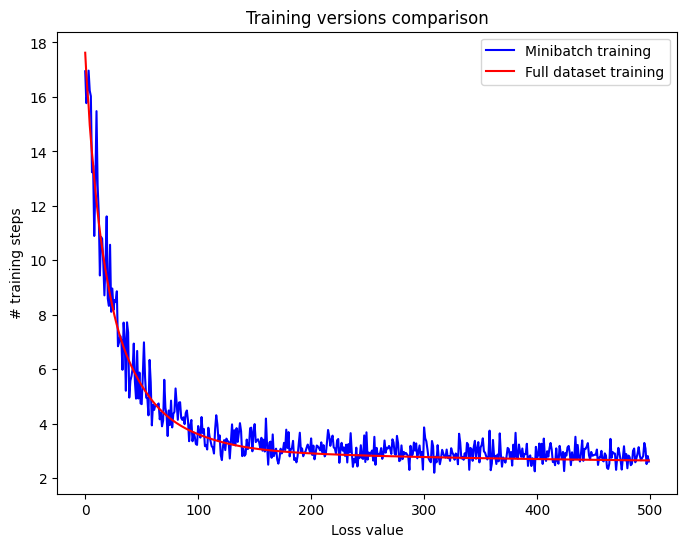

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(losses_minibatch, label='Minibatch training', color='blue')
plt.plot(losses_full_dataset, label='Full dataset training', color='red')

plt.title('Training versions comparison')
plt.xlabel('Loss value')
plt.ylabel('# training steps')

plt.legend()
plt.show()

In view of the results, both versions reach the same final loss result (although the minibatch version achieves this result in much less time as we saw previously).

Another interesting point is that training using the minibatch version is much noisier because the gradients obtained in each step, although useful, do not represent the optimal direction of the entire dataset, only the minibatch used in that step, but still represent a useful direction of optimization in view of the evolution of the loss curve.

In view of the results obtained, we can confirm the superiority of the version based on minibatches. This is why we will do the rest of the experiments using this version.

## Improving the model by adjusting the learning rate

As we have previously verified it seems that we have reached a plateau in our model's loss (around `2.5`) that we can not overcome with more training steps. Other thing that we can tune in order to improve the model is the learning rate. Maybe (really we can't now) the learning rate that we have now, `0.1` is bigger or smaller that the actual one required.

The first thing that we will do in order to achieve a better learning rate is to find a learning rate's range within which we can search for better values.

In order to find this range we will try some learning rates:

In [ ]:
# First I wrap up the training code to not repeat it all over the place

def train_model_by_lr(lr=0.1):
  # Create the model params
  C, W1, b1, W2, b2, parameters = get_base_model_params()

  losses = []

  for i in range(500):
    minibatch_samples_ix = torch.randint(0, X.shape[0], (minibatch_size,))

    emb = C[X[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
    h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
    logits = h @ W2 + b2 # logits.shape -> (32, 27)
    loss = F.cross_entropy(logits, Y[minibatch_samples_ix])
    losses.append(loss.item())

    for p in parameters:
      p.grad = None

    loss.backward()

    for p in parameters:
      p.data += -lr*p.grad

  return losses

In [ ]:
loss_00001_lr = train_model_by_lr(0.0001)
loss_01_lr = train_model_by_lr(0.1)
loss_1_lr = train_model_by_lr(1.0)
loss_10_lr = train_model_by_lr(10)

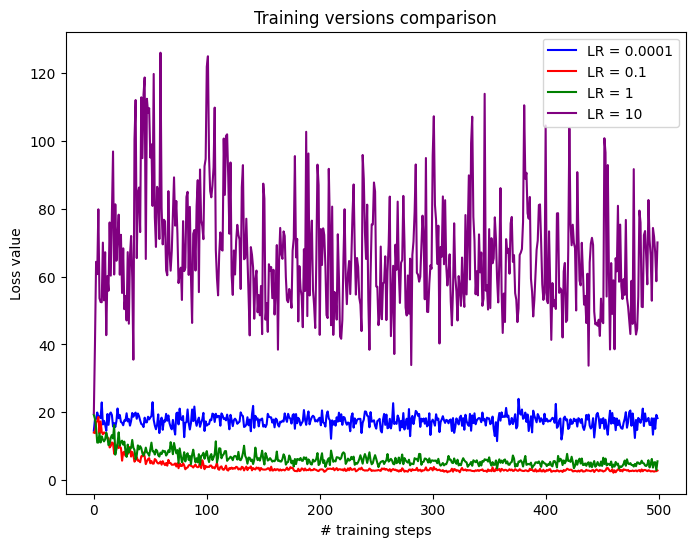

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(loss_00001_lr, label='LR = 0.0001', color='blue')
plt.plot(loss_01_lr, label='LR = 0.1', color='red')
plt.plot(loss_1_lr, label='LR = 1', color='green')
plt.plot(loss_10_lr, label='LR = 10', color='purple')

plt.title('Training versions comparison')
plt.xlabel('# training steps')
plt.ylabel('Loss value')

plt.legend()
plt.show()

As we can see in the plot the extreme LR values (`10` and `0.0001`) do not achieve good results, so the sweetspot seems to be in some place between `0.0001` and `0.1`.

Now that we know the range within which we should search the next step is create a list of possible learning rates values and test all of them during the training. This approach was for the first time proposed on [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186) paper.

So lets start creating the list of plausible values.

Text(0, 0.5, 'Learning rate')

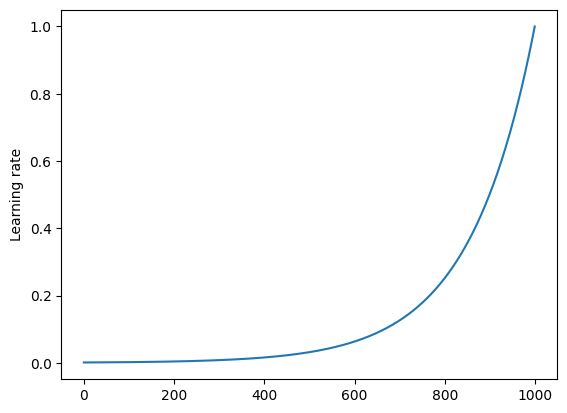

In [ ]:
# We will create 1000 learning rates to test
lrs = torch.linspace(start=0.0001, end=1, steps=1000)

# The problem with this approach is that because the linear increment between
# learning rates maybe we are not to see much difference.
# Usually is better try exponentially increased learning rates, so ...
lrs_exp = torch.linspace(start=-3, end=0, steps=1000)
lrs = 10**lrs_exp

plt.plot(lrs)
plt.ylabel('Learning rate')

Lets train our network in all this learning rates:

Text(0.5, 0, 'Learning rate')

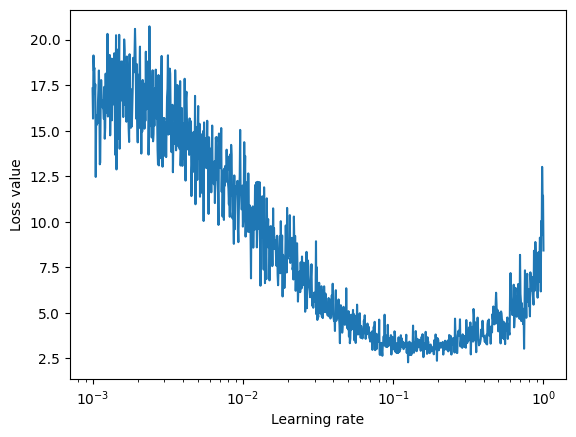

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

losses = []

# One step for each learning rate
for i in range(len(lrs)):
  minibatch_samples_ix = torch.randint(0, X.shape[0], (minibatch_size,))

  emb = C[X[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y[minibatch_samples_ix])
  losses.append(loss.item())

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -lrs[i]*p.grad


plt.plot(lrs, losses)
plt.xscale('log')
plt.ylabel('Loss value')
plt.xlabel('Learning rate')

What we observe in the plot is that, at the begining, with very low learning rates, the network is not learning anything, the learning rate is so small that it can not effectively alter the networks weights. At the same time when the learning rate is to high the training becomes unstable (this is represented in the right side of the plot). It seem that the best loss values are between `0.05` and `0.5` (more or less). Lets make a zoom in this range:

Text(0.5, 0, 'Learning rate')

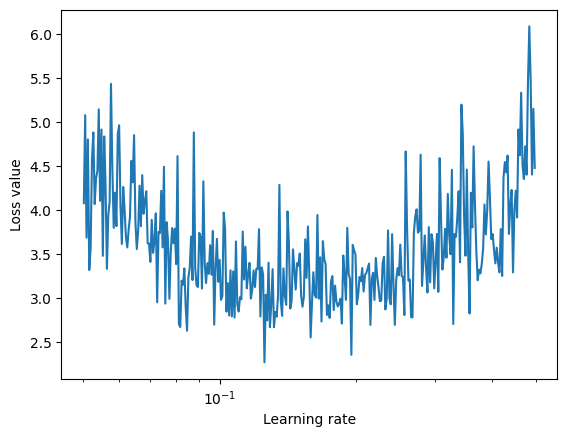

In [ ]:
zoomed_ixs = (0.05<=lrs) & (lrs<0.5)
zoomed_lrs = lrs[zoomed_ixs]
zoomed_losses = [losses[i] for i, filter in enumerate(zoomed_ixs) if filter ]

plt.plot(zoomed_lrs, zoomed_losses)
plt.xscale('log')
plt.ylabel('Loss value')
plt.xlabel('Learning rate')

It seems that, as we can see in the plot, the best learning rate (the one who gets one less loss) is `0.1`. The learning rate turned out to be the one initially chosen, but this was just a coincidence, it could have been any other value.

### Applying learning rate decay

Now that we know the good initial learning rate one thing that we can do in order to achieve better results in our loss value is:
* Train our network during some steps with this initial learning rate `0.1`
* When the training is stabilized apply a decay to this learning rate to see if with smaller learning rates (slowing the training) we can achieve better results.

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

#### WITHOUT LR DECAY: 20000 steps with the same LR ####
losses_without_lr_decay = []

for i in range(40000):
  minibatch_samples_ix = torch.randint(0, X.shape[0], (minibatch_size,))

  emb = C[X[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y[minibatch_samples_ix])
  losses_without_lr_decay.append(loss.item())

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad


# Calculating the final loss on the entire dataset
emb = C[X] # emb.shape -> (32, 3, 2)
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
logits = h @ W2 + b2 # logits.shape -> (32, 27)
loss = F.cross_entropy(logits, Y)
final_loss_without_LR_decay = loss.item()

############################################
############################################


#### WITH LR DECAY: 10000 steps with LR=0.1, then 10000 steps with LR=0.01 ####
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

losses_with_lr_decay = []

for i in range(10000):
  minibatch_samples_ix = torch.randint(0, X.shape[0], (minibatch_size,))

  emb = C[X[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y[minibatch_samples_ix])
  losses_with_lr_decay.append(loss.item())

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

# One step for each learning rate
for i in range(30000):
  minibatch_samples_ix = torch.randint(0, X.shape[0], (minibatch_size,))

  emb = C[X[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Y[minibatch_samples_ix])
  losses_with_lr_decay.append(loss.item())

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.01*p.grad

# Calculating the final loss on the entire dataset
emb = C[X] # emb.shape -> (32, 3, 2)
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
logits = h @ W2 + b2 # logits.shape -> (32, 27)
loss = F.cross_entropy(logits, Y)
final_loss_with_LR_decay = loss.item()
############################################
############################################

Text(0, 0.5, 'Loss value')

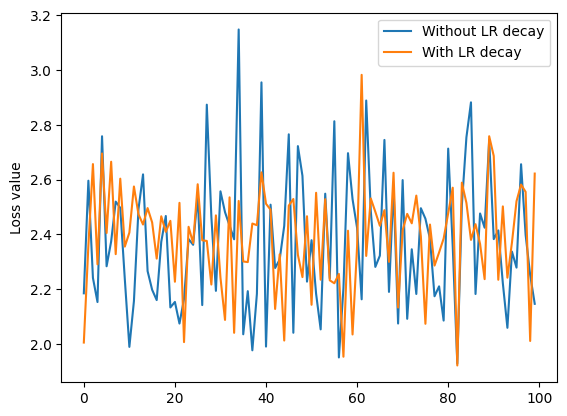

In [ ]:
plt.plot(losses_without_lr_decay[-100:], label="Without LR decay")
plt.plot(losses_with_lr_decay[-100:], label="With LR decay")
plt.legend()
plt.ylabel('Loss value')

In [ ]:
print(f"Without LR decay --> Average (last 100 steps): {np.mean(losses_without_lr_decay[-100:])}. Last loss value: {losses_without_lr_decay[-1]}. Final loss in the entire dataset: {final_loss_without_LR_decay}")
print(f"With LR decay --> Average (last 100 steps): {np.mean(losses_with_lr_decay[-100:])}, Last loss value: {losses_with_lr_decay[-1]}. Final loss in the entire dataset: {final_loss_with_LR_decay}")

Without LR decay --> Average (last 100 steps): 2.3716145086288454. Last loss value: 2.14642333984375. Final loss in the entire dataset: 2.387366771697998
With LR decay --> Average (last 100 steps): 2.3904610431194304, Last loss value: 2.6222031116485596. Final loss in the entire dataset: 2.373077630996704


Taking a look to the plot we see that although there is not a great improve using the Learning rate decay it seems to be lower with the Learning rate decay. We can confirm this intuition taking a look to the Average and last loss, both values are better for the Learning rate decay training version.

## Dealing with the overfitting

Considering the previous results (very low loss values) we can think that we have achieved a very good model, but there is a trap here. We are evaluating our model (the final loss) in samples that the model has seen previously during the training, so probably what the model is doing is overfitting the network to our training dataset, or in other words, our network is memorizing the training dataset. This is something undesirable: we want that our model learns to generalize and in this way it can show good results when facing samples that it hasn't been seen previously.

One of the factors that allow the network to overtrain easily is the large number of parameters, it is very easy to simply add more parameters giving to the network the capacity to memorize even better the training dataset, but as we have said previously this is not what we want.

What we do to overcome this situation is split the dataset in three splits:
* Training split (usually 80% of the entire dataset): This split will be used to train the model.
* Dev/validation split  (usually 10% of the entire dataset): This split will help us to compare and modify hyperparameters: number of layers, number of neurons, LR... But the weights of the model will not be optimized based on these samples ie. this split is not used for training the model.
* Test split  (usually 10% of the entire dataset): This split will be used to give a final metric for our model and compare it with other models out there that solve the same problem.

In the next cell we have build a function that create the three splits:

In [ ]:
def build_dataset(dataset_words):
  """
  This function receive a list of words and return the both samples tensors:
  * X tensor with the inputs (the indexes of the character's sequence)
  * Y tensor with the labels (the indexes of the actual character that follows the sequence)
  """
  block_size = 3
  X, Y = [], []

  for word in dataset_words:
    input = [0]*block_size
    for ch in word+'.':
      ch_ix = stoi[ch]
      X.append(input.copy())
      Y.append(ch_ix)
      input = input[1:] + [ch_ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y


import random
random.seed(42)
random.shuffle(words)

# Now we need to calculate the starting and the ending indexes for every split
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

print(f"Samples in train split: {Ytr.shape[0]}")
print(f"Samples in train split: {Ydev.shape[0]}")
print(f"Samples in train split: {Ytest.shape[0]}")

Samples in train split: 182437
Samples in train split: 22781
Samples in train split: 22928


Now that we have created de splits we can train again the model but just using the training samples, when the training ends we will evaluate the model using the dev splits, what will give us a true metric about how good our model is, because this evaluation will be done with samples that the neural network has not seen during the training (the weights has not been optimized for this samples)

In [ ]:
# Create the model params
C, W1, b1, W2, b2, parameters = get_base_model_params()

# Train with the training split
for i in range(30000):
  minibatch_samples_ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  emb = C[Xtr[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 100)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Ytr[minibatch_samples_ix])

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad


# Evaluate on the train split
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr).item()
print(f"Loss on the train split: {train_loss}")

# Evaluate on the dev split
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev).item()
print(f"Loss on the dev split: {dev_loss}")

Loss on the train split: 2.3999733924865723
Loss on the dev split: 2.399718761444092


It results that we have similar loss values in both splits, train and dev, which is a good sign because it means that the knowledge that our model is adquiring via the train split is generalizable and can be transfered to data that has not been previously seen by the model. This also means that our model is not powerful enough to memorize the train split, so we are underfitting to the train split, so maybe creating a more complez model (a model with more parameters we can achieve better loss values in dev split).

There is multiple ways to increase the model complexity: we can add more layers, more neurons on a layers ... Here we try add more neurons to one of the layers, specifically, we will increase the number of neurons in the hidden layer from 100 to 300, this also means to increase the number of input neurons in the output layers. Lets implement it:

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocabulary_size, embedding_dimensional_space), generator=g)
W1 = torch.randn((6, 300), generator=g)
b1 = torch.rand(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.rand(27, generator=g)

parameters = [C, W1, b1, W2, b2]

# Number of parameters in the network
model_numel = sum([p.numel() for p in parameters])
print(f"Parameters in the extended model: {model_numel}")

for p in parameters:
  p.requires_grad = True

Parameters in the extended model: 10281


We can see that the number of parameters in the model has increased from `3481` (the size of the first model) to `10281`.

In [ ]:
for i in range(30000):
  minibatch_samples_ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  emb = C[Xtr[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 300)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Ytr[minibatch_samples_ix])

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

# Evaluate on the train split
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr).item()
print(f"Loss on the train split: {train_loss}")

# Evaluate on the dev split
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev).item()
print(f"Loss on the dev split: {dev_loss}")

Loss on the train split: 2.4600369930267334
Loss on the dev split: 2.4664218425750732


The loss in train and dev is still almost the same, let see if retraining the previous weights with a smaller learning rate help:

In [ ]:
for i in range(60000):
  minibatch_samples_ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  emb = C[Xtr[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 6)) @ W1 + b1) # h.shape -> (32, 300)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Ytr[minibatch_samples_ix])

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.01*p.grad

# Evaluate on the train split
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr).item()
print(f"Loss on the train split: {train_loss}")

# Evaluate on the dev split
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 6)) @ W1 + b1)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev).item()
print(f"Loss on the dev split: {dev_loss}")

Loss on the train split: 2.2872259616851807
Loss on the dev split: 2.3044514656066895


Now we get the best loss result until now but still have the issue that train and dev loss are quite similar what means, as we have said previously, that we can increase the complexity of the model. Maybe the bottleneck right now is the embedding size (maybe 2 dimmensions are not enough to pack all the information that come from 3 tokens combinations of 27 uniqes tokens) so increasing the embeddings dimensional space can be the soultion.

(It is important to notice that with the increase of the neuron amount in the hidden layer we have achieved a improvement in the loss, the dev loss going from `2.46642` to `2.30228`)

Before increasing the dimensional space we will take advantage of the fact that the current one has 2 dimensions, and therefore can be represented visually, to show how the embeddings of each character are distributed in these two dimensions.

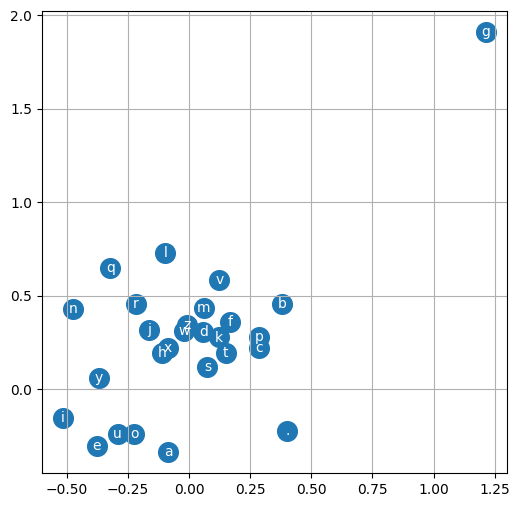

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid("minor")

This plot reveals a lot of interesting information:
* As we can see all the vowels are clustered togethers, what means that the neural network in some sense undertand that are similar characters, what means that can be used interchangibly. This make sense because any consonant can be followed by any vowel.
* Another interesting point is that the `'.'` and `'g'` characters seem to form two cluster by themselves. It is difficult to say why this happens with `'g'` but make sense in the case of the `'.'`

What is really important is that the distribution of the embeddings within its dimensional space is not random, as it began, but has been redistributed in a way that makes sense.

## Extending the embeddings dimensional space

We will use a 10 dimmensions embedding space and reduce the number of neurons in the hidden layer from 300 to 200 (to keep the number of neurons relatively small)

In [ ]:
embedding_dimensional_space = 10

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, embedding_dimensional_space), generator=g)
W1 = torch.randn((embedding_dimensional_space * block_size, 200), generator=g)
b1 = torch.rand(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.rand(27, generator=g)

parameters = [C, W1, b1, W2, b2]

# Number of parameters in the network
model_numel = sum([p.numel() for p in parameters])
print(f"Parameters in the extended model: {model_numel}")

for p in parameters:
  p.requires_grad = True

Parameters in the extended model: 11897


In the following cells we will train the extended model in three steps:
* First we will train during `50000` steps with LR=`0.1`
* Then we will train during `50000` steps with LR=`0.01` to show the loss in dev and train
* Finally we will train during `50000` steps with LR=`0.01`

One thing that we need to take into account when coding the training loop and the evaluation pass is to redefine the dimmension that we set on the method `view()`. We need to do this because the change in the embeddings dimmensional space. Previously we have sequence of 3 embeddings each of them which 2 dimmensions embeddings but now we use the same numbers of embeddings but each of them have 10 dimensions (`3 * 2 = 6` -> `3 * 10 = 30`)

In [ ]:
for i in range(50000):
  minibatch_samples_ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  emb = C[Xtr[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 30)) @ W1 + b1) # h.shape -> (32, 200)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Ytr[minibatch_samples_ix])

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.1*p.grad

# Evaluate on the train split
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr).item()
print(f"Loss on the train split: {train_loss}")

# Evaluate on the dev split
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev).item()
print(f"Loss on the dev split: {dev_loss}")

Loss on the train split: 2.2582967281341553
Loss on the dev split: 2.3173909187316895


In [ ]:
for i in range(50000):
  minibatch_samples_ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  emb = C[Xtr[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 30)) @ W1 + b1) # h.shape -> (32, 200)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Ytr[minibatch_samples_ix])

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.01*p.grad

# Evaluate on the train split
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr).item()
print(f"Loss on the train split: {train_loss}")

# Evaluate on the dev split
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev).item()
print(f"Loss on the dev split: {dev_loss}")

Loss on the train split: 2.12154221534729
Loss on the dev split: 2.1796085834503174


In [ ]:
for i in range(50000):
  minibatch_samples_ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))

  emb = C[Xtr[minibatch_samples_ix]] # emb.shape -> (32, 3, 2)
  h = torch.tanh(emb.view((-1, 30)) @ W1 + b1) # h.shape -> (32, 200)
  logits = h @ W2 + b2 # logits.shape -> (32, 27)
  loss = F.cross_entropy(logits, Ytr[minibatch_samples_ix])

  for p in parameters:
    p.grad = None

  loss.backward()

  for p in parameters:
    p.data += -0.01*p.grad

# Evaluate on the train split
emb = C[Xtr]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
train_loss = F.cross_entropy(logits, Ytr).item()
print(f"Loss on the train split: {train_loss}")

# Evaluate on the dev split
emb = C[Xdev]
h = torch.tanh(emb.view((-1, 30)) @ W1 + b1)
logits = h @ W2 + b2
dev_loss = F.cross_entropy(logits, Ydev).item()
print(f"Loss on the dev split: {dev_loss}")

Loss on the train split: 2.1165521144866943
Loss on the dev split: 2.1774654388427734


At the end of the training we notice two points:
* We have largely improve our model, now our dev loss is `2.177`. The best model until now!
* We also see that the train loss and dev starts to diverge. The train loss starts to be better than the dev loss, which is an indication that the network is beginning to overfit the training split.

## Sampling from the model

Now that we have a good model we can use it to create new names (make more names)

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  # 0 is the index of '.' and 3 is the block_size
  input = [0] * 3
  name = ''
  while True:
    emb = C[torch.tensor([input])]
    h = torch.tanh(emb.view((1, -1)) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    predicted_char_ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    input = input[1:] + [predicted_char_ix]
    next_char = itos[predicted_char_ix]
    if next_char == '.':
      print(name)
      break
    else:
      name += next_char

mora
kayanniellend
ryla
remurccebdrlee
azered
eliah
miloe
leigh
esmana
septy
malara
nyserger
shiriel
kindreeller
nocuon
ubentel
ryyah
faehsy
majahston
azhia


We can see that our recently generated names looks more like real names that the names generated with the bigram model. There is no more one or two character names and all the names seems pronounceable.